# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation},
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os
import cv2

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')
I_2 = mat['I_noisy1']


def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g/g.sum()


def non_local_means_filter(img, search, size, alpha, sigma):
    gaussian = fgaussian(size, sigma)
    X, Y = img.shape
    result = img.copy()

    for i in range(search, X-search):
        for j in range(search, Y-search):
            Vx = img[i - search//2 : i + search//2 + 1, j - search//2 : j + search//2 + 1]
            Nx = img[i - size//2 : i + size//2 + 1, j - size//2 : j + size//2 + 1]
            
            Zx = 0
            for k in range(Vx.shape[0]):
                for l in range(Vx.shape[1]):
                    Np = img[i - search//2 + k - size//2 : i - search//2 + k + size//2 + 1, j - search//2 + l - size//2 : j - search//2 + l + size//2 + 1]
                    gn = (gaussian*Np - gaussian*Nx)
                    X2 = (np.multiply(gn, gn)).sum()

                    Zx += np.exp(-X2/(alpha * sigma**2))

            Ix = 0
            for m in range(Vx.shape[0]):
                for n in range(Vx.shape[1]):
                    Np = img[i - search//2 + m - size//2 : i - search//2 + m + size//2 + 1, j - search//2 + n - size//2 : j - search//2 + n + size//2 + 1]
                    gn = (gaussian*Np - gaussian*Nx)
                    X2 = (np.multiply(gn, gn)).sum()
                    wpx = (1/Zx)*np.exp(-X2/(alpha * sigma**2))

                    Ix += wpx * img[i - search//2 + m, j - search//2 + n]
                    
            result[i, j] = Ix
    return result

def bilateral_filter(img, size, delta, delta_r):
    kernel = fgaussian(size, delta)
    X, Y = img.shape
    n_kernel = np.zeros(kernel.shape)
    img_copy = img.copy()
    for i in range(size//2, X - size//2):
        for j in range(size//2, Y - size//2):
            w = np.zeros(shape=(size, size))
            temp_w = np.zeros(shape=(size, size))
            for k in range(size):
                for l in range(size):
                    n_kernel[k][l] = np.exp((-(kernel[k][l] - img[i][j]**2)/(2*delta_r**2)))
                    w[k][l] = img[i + k - (size//2)][j + l - (size//2)]
                    temp_w[k][l] = w[k][l] * kernel[k][l] * n_kernel[k][l]
            img_copy[i, j] = temp_w.sum()/kernel.sum()
    return img_copy



Czas działania NON LOCAL MEANS:
3min 21s ± 684 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


Czas działania BILATERAL:
13.2 s ± 63.4 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


Czas działania GAUSS:
587 µs ± 85.9 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)


<TimeitResult : 587 µs ± 85.9 µs per loop (mean ± std. dev. of 2 runs, 3 loops each)>

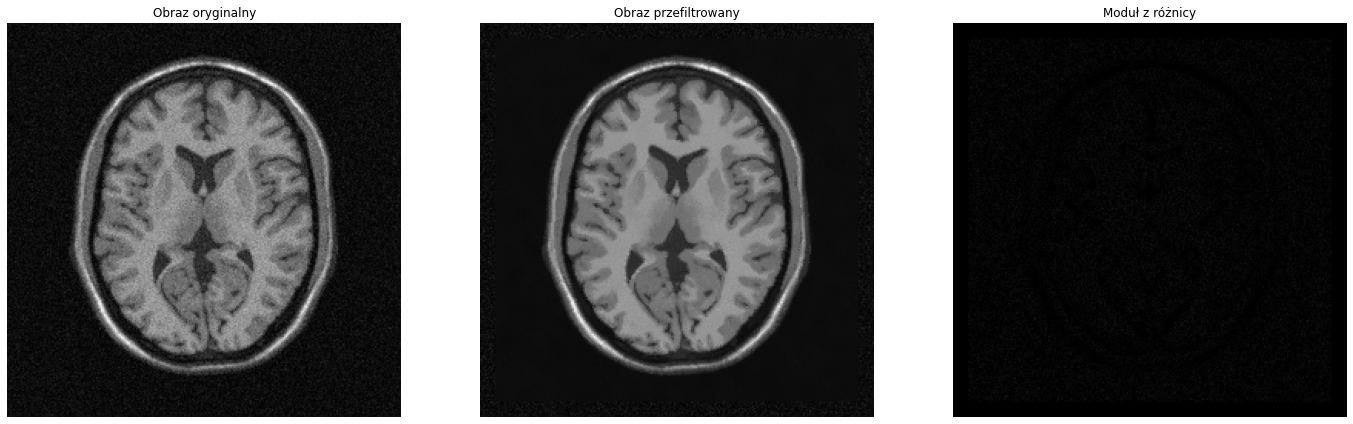

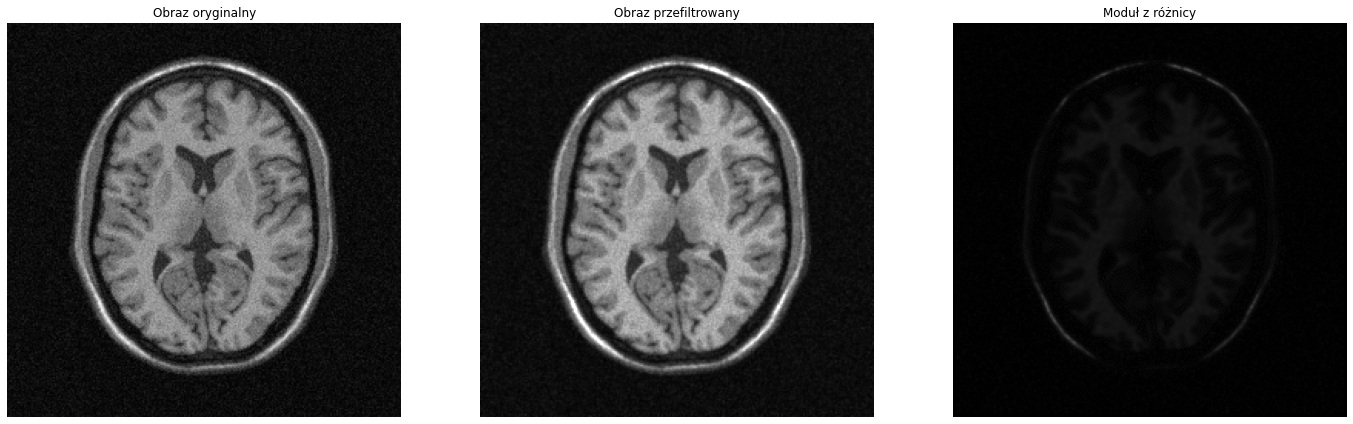

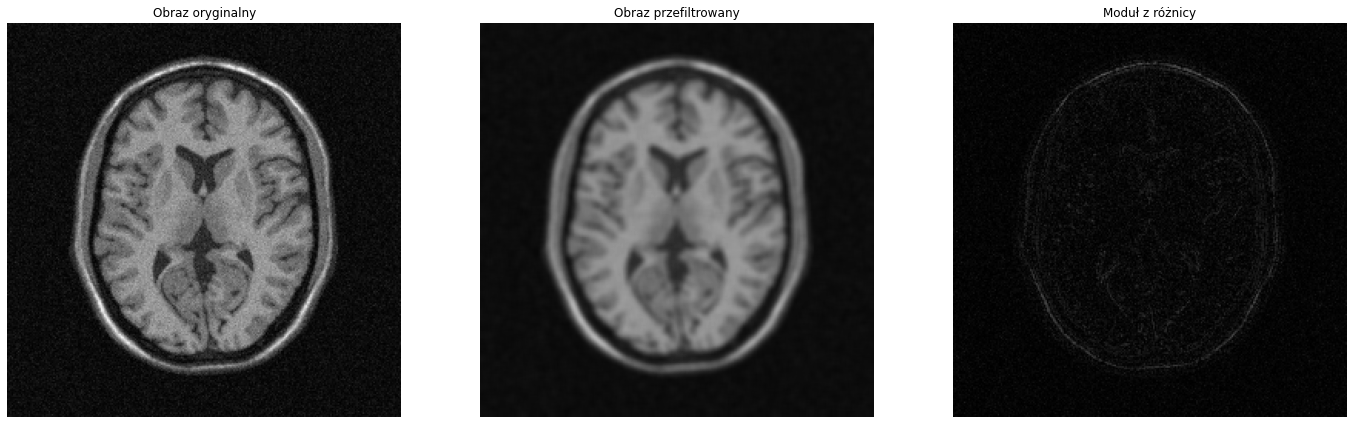

In [2]:
filtered = non_local_means_filter(I_2, 10, 4, 2.5, 1.5)
I_bil = bilateral_filter(I_2, 5, 0.5, 300)
I_gauss_cv = cv2.GaussianBlur(I_2, (5,5), 3)

def disp_img_and_filtered(img, filtered):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(24, 8)
    ax[0].imshow(img, 'gray', vmin=0, vmax=256)
    ax[0].axis("off")
    ax[0].set_title("Obraz oryginalny")

    ax[1].imshow(filtered, 'gray', vmin=0, vmax=256)
    ax[1].axis("off")
    ax[1].set_title("Obraz przefiltrowany")
    
    mod = np.abs(img - filtered)
    ax[2].imshow(mod, 'gray', vmin=0, vmax=256)
    ax[2].axis("off")
    ax[2].set_title("Moduł z różnicy")

disp_img_and_filtered(I_2, filtered)
disp_img_and_filtered(I_2, I_bil)
disp_img_and_filtered(I_2, I_gauss_cv)

print("\n\nCzas działania NON LOCAL MEANS:")
%timeit -r 2 -n 3 -o non_local_means_filter(I_2, 10, 4, 2.5, 1.5)

print("\n\nCzas działania BILATERAL:")
%timeit -r 2 -n 3 -o bilateral_filter(I_2, 5, 0.5, 300)

print("\n\nCzas działania GAUSS:")
%timeit -r 2 -n 3 -o cv2.GaussianBlur(I_2, (5,5), 3)

Zdecydowanie najlepsze wyniki daje metoda NLM - niemal całkowicie usuwa szum, zachowując ostrość obrazu. Jedynym problemem są brzegi, jednak zakładając, że wszystkie obrazy swoją 'treść' mają skupioną w centrum, nie jest to istotne. Filtracja bilateralna rozmazuje szum, jednak nie usuwa go w pełni. Filtracja Gaussa rozmazuje obraz, zatracając jego ostrość. Filtracja NLM daje zatem najlepsze rezultaty, jednak kosztem czasu obliczeń (który jest wyjątkowo długi ~ 3.5 minuty). Zgodnie z oczekiwaniami filtracja Gaussa jest najszybsza, natomiast czas obliczeń filtracji bilateralnej znajduje sie pomiędzy dwoma wspomnianymi metodami.
